In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


201 investors in 17-quarter 13F data:  
* instruments: 10972  


df_sub merge with RDC (COMNAME, industry info):
* 5 instru not in RDC
* instruments: 10972 - 5 = 10967  


merge with mkt cap data:
* 27 instru with no mkt cap at all
* 243 instru with no full mkt cap for 17 time points (including 27 above)
* instruments: 10928

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# read in 13F results
file_name = '/content/gdrive/My Drive/capstone/full database/Results_20160630_20200630.csv'
df = pd.read_csv(file_name)
df['HOLDDATE'] = df['HOLDDATE'].str.replace(r' 00:00:00', '')

In [6]:
n_investors = df.LGCYINVESTORID.nunique()
print('There are {} investors in 13F data.'.format(n_investors))

There are 6537 investors in 13F data.


In [7]:
# read in list of investors of interest
df_investors = pd.read_csv('/content/gdrive/My Drive/capstone/full database/active_investor_list.csv')
# df_investors = df_investors[df_investors.isActive==True]

ls_investors = df_investors.LgcyInvestorId.to_list()
print('There are {} investors which are we interested in.'.format(len(ls_investors)))

There are 201 investors which are we interested in.


In [8]:
active_ls_investors = df_investors[df_investors.isActive==True]

In [9]:
# get those in predefined list
df_sub = df.loc[df['LGCYINVESTORID'].isin(ls_investors),['INSTRID', 'COMNAME', 'LGCYINVESTORID', 'FULLNAME', 'HOLDDATE', 'SHSHLDVAL']]

# calculate the sum of SHSHLDVAL for each investor in each quarter
df_sub['SHSHLDVAL_Sum_ByQuarter'] = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).transform('sum').drop(['INSTRID', 'FULLNAME'], axis = 1)

# calculate the (13F only) pct of the SHSHLDVAL of each instrument in its investor's sum of SHSHLDVAL for each quarter 
# (i.e. revised version of 'PCTPORTFOLIO', so that sum up to 1)
df_sub['PCTPORTFOLIO_13F'] = df_sub['SHSHLDVAL'] / df_sub['SHSHLDVAL_Sum_ByQuarter']

In [10]:
sum(df_sub.drop_duplicates(subset=['INSTRID','COMNAME']).COMNAME.isna())

5

In [11]:
df_sub.drop_duplicates(subset=['INSTRID','COMNAME'])[df_sub.drop_duplicates(subset=['INSTRID','COMNAME']).COMNAME.isna()]

,INSTRID,COMNAME,LGCYINVESTORID,FULLNAME,HOLDDATE,SHSHLDVAL,SHSHLDVAL_Sum_ByQuarter,PCTPORTFOLIO_13F
17311995,18040214097,NaN,2006452,Citadel Advisors LLC,2017-06-30,1940648.18,5.112838e+10,3.795638e-05
17434408,18040229076,NaN,2006452,Citadel Advisors LLC,2020-06-30,269235.57,6.344707e+10,4.243467e-06
17434833,18040229403,NaN,2002875,"American Century Investment Management, Inc.",2020-06-30,65729096.27,1.052599e+11,6.244455e-04
17435157,18040229077,NaN,2001935,"UBS Financial Services, Inc.",2020-06-30,116244.01,1.839275e+11,6.320098e-07
17435428,18040229670,NaN,2001935,"UBS Financial Services, Inc.",2020-06-30,7274.57,1.839275e+11,3.955128e-08


In [12]:
sum(df_sub.drop_duplicates(subset=['INSTRID','COMNAME']).COMNAME.isna())/len(df_sub.drop_duplicates(subset=['INSTRID','COMNAME']))

0.00045570543200874956

In [13]:
len(df_sub)

3131694

## Remove instruments not in RDC (i.e. NA in Comname)

In [14]:
len(df_sub.loc[df_sub['COMNAME'].isna(),:]) # There are 13 rows with instruments not in RDC

13

In [15]:
df_sub = df_sub.dropna()
len(df_sub)

3131681

In [16]:
len(set(df_sub['INSTRID']))

10967

In [17]:
vanguard_id = '2004260'

## Fill in missing time

In [18]:
def fill_in_missing_date(df, dateColName, valColName):
  '''
  df: Column for investor id is 'LGCYINVESTORID' and column for instrumnet id is 'INSTRID'
  dateColName: Fill in all the dates starting from the earlist to latest mentioned in this column
  valColName: The column you want to fill in missing value.
              The missing value will be filled as 0.

  Return: a dataframe with filled missing value as 0 in valColName
  '''
  # create pivot table with id and date
  df_pivot = pd.pivot_table(df,index='LGCYINVESTORID', columns= dateColName, values=valColName)
  # fill in the missing value as 0. Each investor have data for all time stamp.
  df_pivot.fillna(0,inplace=True)

  # turn the pivot table to original format
  df_stack = df_pivot.stack().reset_index()
  df_stack.rename(columns = {0: valColName},inplace=True)
  # map back the original df
  df = pd.merge(df.drop(columns=valColName),df_stack,on = ['LGCYINVESTORID',dateColName])
  return df_stack


## Feature: Asset allocation


In [20]:
asset_aloc = pd.read_csv('/content/gdrive/My Drive/capstone/full database/AssetAllocWithDesc.csv')

In [37]:
asset_aloc[asset_aloc.LgcyInvestorId.isin(ls_investors)]

,LgcyInvestorId,FullName,AstAllocReg,AstAllocRegDesc,EqAstAlloc,EqAstAllocDesc,FIAstAlloc,FIAstAllocDesc,CashAstAlloc,CashAstAllocDesc,TotAstAlloc,TotAstAllocDesc
0,7016524,"Hartford Funds Management Company, LLC",AAREG7,Total Assets,AARANGE7,$1.0-2.4B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE13,$100-149.9B
1,2004000,"Nomura Asset Management Co., Ltd.",AAREG5,Australasia Non-Domestic,AARANGE5,$200-499M,AARANGE6,$500-999M,AARANGE2,None ($0),AARANGE7,$1.0-2.4B
11,2455426,"Adage Capital Management, L.P.",AAREG7,Total Assets,AARANGE11,$20.0-49.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE11,$20.0-49.9B
28,2536411,"Pharo Management, Inc.",AAREG7,Total Assets,AARANGE6,$500-999M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE11,$20.0-49.9B
36,2575182,SEI Investments Management Corporation,AAREG6,Other Non-Domestic,AARANGE2,None ($0),AARANGE2,None ($0),AARANGE2,None ($0),AARANGE2,None ($0)
...,...,...,...,...,...,...,...,...,...,...,...,...
6300,3318171,"BlueMountain Capital Management, LLC",AAREG7,Total Assets,AARANGE4,$25-199M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE10,$10.0-19.9B
6325,2906273,"Great Point Partners, LLC",AAREG7,Total Assets,AARANGE7,$1.0-2.4B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE8,$2.5-4.9B
6334,2507775,Balyasny Asset Management LP,AAREG7,Total Assets,AARANGE9,$5.0-9.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE13,$100-149.9B
6356,2002582,Victory Capital Management Inc.,AAREG7,Total Assets,AARANGE12,$50.0-99.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE14,Over $150B


In [22]:
asset_aloc[asset_aloc.LgcyInvestorId.isin(ls_investors)]['TotAstAlloc'].value_counts(normalize=True)

AARANGE11    0.208955
AARANGE1     0.164179
AARANGE10    0.129353
AARANGE14    0.119403
AARANGE12    0.094527
AARANGE13    0.069652
AARANGE8     0.039801
AARANGE7     0.039801
AARANGE2     0.039801
AARANGE9     0.034826
AARANGE3     0.019900
AARANGE6     0.014925
AARANGE5     0.014925
AARANGE4     0.009950
Name: TotAstAlloc, dtype: float64

In [24]:
asset_aloc['EqAstAlloc'].value_counts()

AARANGE4     1978
AARANGE5     1477
AARANGE6      794
AARANGE7      616
AARANGE3      412
AARANGE2      351
AARANGE8      307
AARANGE9      195
AARANGE10     131
AARANGE11     114
AARANGE12      52
AARANGE13      28
AARANGE14      24
AARANGE1       16
Name: EqAstAlloc, dtype: int64

In [25]:
asset_aloc['TotAstAlloc'].value_counts(normalize=True)

AARANGE1     0.251819
AARANGE5     0.188825
AARANGE6     0.124284
AARANGE7     0.114998
AARANGE4     0.080328
AARANGE8     0.062839
AARANGE2     0.053243
AARANGE9     0.035289
AARANGE11    0.027859
AARANGE10    0.026157
AARANGE12    0.009751
AARANGE3     0.009441
AARANGE14    0.008822
AARANGE13    0.006346
Name: TotAstAlloc, dtype: float64

In [26]:
asset_aloc[asset_aloc['TotAstAlloc'] == 'AARANGE1']

,LgcyInvestorId,FullName,AstAllocReg,AstAllocRegDesc,EqAstAlloc,EqAstAllocDesc,FIAstAlloc,FIAstAllocDesc,CashAstAlloc,CashAstAllocDesc,TotAstAlloc,TotAstAllocDesc
2,5928246,"Hunt Lane Capital Management, LLC",AAREG7,Total Assets,AARANGE5,$200-499M,AARANGE3,Under $25M,AARANGE1,Unknown,AARANGE1,Unknown
6,10264811,Citizens National Bank Trust Department,AAREG7,Total Assets,AARANGE5,$200-499M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
9,2006029,Mandatum Henkivakuutusosakeyhtiö,AAREG7,Total Assets,AARANGE7,$1.0-2.4B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
13,4974839,Fosun International Ltd,AAREG7,Total Assets,AARANGE9,$5.0-9.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
18,2005462,Comgest S.A.,AAREG7,Total Assets,AARANGE11,$20.0-49.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
6475,2004323,Gilder Gagnon Howe & Co. LLC,AAREG7,Total Assets,AARANGE10,$10.0-19.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
6477,6310614,Bristol County Savings Bank,AAREG7,Total Assets,AARANGE4,$25-199M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
6479,3726932,Turiya Advisors Asia Limited,AAREG7,Total Assets,AARANGE5,$200-499M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
6481,5844179,Carve Capital AB,AAREG7,Total Assets,AARANGE4,$25-199M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown


In [27]:
own2code = pd.read_excel('/content/gdrive/My Drive/capstone/full database/Own2Code.xlsx')

In [28]:
own2code[own2code['Type_'] == 11]

,Type_,Code,Desc_
446,11,AAREG1,Domestic Assets
447,11,AAREG2,North America Non-Domestic
448,11,AAREG3,Europe Non-Domestic
449,11,AAREG4,Asia & Far East Non-Domestic
450,11,AAREG5,Australasia Non-Domestic
451,11,AAREG6,Other Non-Domestic
452,11,AAREG7,Total Assets


## Feature: pctportofolio with aggregated market cap

In [19]:
mktcap = pd.read_csv('/content/gdrive/My Drive/capstone/full database/MktCap_MktCapSize_20160630_20200630.csv')
mktcap

,InstrId,EffectDate,PrcCloseAct,NumOfShOut,MktCap,MktCapSize
0,8589934595,2016-06-30,0.0200,29520523,5.904105e+05,NanoCap
1,8589934597,2016-06-30,18.5100,16347483,3.025919e+08,SmallCap
2,8589934599,2016-06-30,0.0700,40000000,2.800000e+06,NanoCap
3,8589934600,2016-06-30,1.2100,2750000,3.327500e+06,NanoCap
4,8589934603,2016-06-30,33.7200,50700002,1.709604e+09,SmallCap
...,...,...,...,...,...,...
1987028,8590939913,2020-06-30,0.0800,1168546867,9.348375e+07,MicroCap
1987029,8590939914,2020-06-30,9.9800,3512766,3.505740e+07,NanoCap
1987030,8590939915,2020-06-30,103.0400,135980227,1.401140e+10,LargeCap
1987031,8590939917,2020-06-30,0.0884,467734596,4.134774e+07,NanoCap


In [20]:
# number of instruments not in mktcap data
len(set(df_sub['INSTRID']) - set(mktcap['InstrId']))

27

In [23]:
merge = pd.merge(df_sub, mktcap, how='inner', left_on=['INSTRID', 'HOLDDATE'], right_on=['InstrId', 'EffectDate'])
merge.drop(columns=['InstrId', 'EffectDate'])

agg_mktcap_pivot = pd.pivot_table(merge,index = ['LGCYINVESTORID', 'HOLDDATE'], columns = ['MktCapSize'],values=['PCTPORTFOLIO_13F'],aggfunc=[np.sum],fill_value=0)

investor_set = set(agg_mktcap_pivot.index.get_level_values('LGCYINVESTORID'))
holddate_set = set(agg_mktcap_pivot.index.get_level_values('HOLDDATE'))

mktcap_cat = ['PctLargeCap', 'MegaCap', 'MicroCap', 'MidCap', 'NanoCap', 'SmallCap']

In [25]:
# Number of isntruments with no mkt cap or no full 17 time points
# len(set(pd.merge(df_sub, mktcap, how='left', 
#                  left_on=['INSTRID', 'HOLDDATE'], 
#                  right_on=['InstrId', 'EffectDate']).loc[merge['InstrId'].isna(),:].INSTRID))

In [26]:
len(set(merge['INSTRID']))

10928

In [27]:
agg_mktcap_pivot

sum            ...                  
                          PCTPORTFOLIO_13F            ...                  
MktCapSize                        LargeCap   MegaCap  ... NanoCap  SmallCap
LGCYINVESTORID HOLDDATE                               ...                  
2000264        2016-06-30         0.729248  0.212474  ...     0.0  0.000000
               2016-09-30         0.773931  0.175392  ...     0.0  0.000000
               2016-12-31         0.728076  0.221342  ...     0.0  0.000000
               2017-03-31         0.848514  0.094321  ...     0.0  0.000000
               2017-06-30         0.784105  0.164908  ...     0.0  0.000000
...                                    ...       ...  ...     ...       ...
10110259       2019-06-30         0.571071  0.173928  ...     0.0  0.027733
               2019-09-30         0.647565  0.117568  ...     0.0  0.014651
               2019-12-31         0.684269  0.139909  ...     0.0  0.012224
               2020-03-31         0.694243  0.190701  ...     0.0  0.023105
               2020-06-30         0.674690  0.182061  ...     0.0  0.033155

[3285 rows x 6 columns]

In [28]:
agg_mktcap_pivot.columns = mktcap_cat
agg_mktcap_pivot = agg_mktcap_pivot.reset_index()
for inv in investor_set:
  holddates = set(agg_mktcap_pivot[agg_mktcap_pivot['LGCYINVESTORID']==inv]['HOLDDATE'].to_list())
  if len(holddates) < len(holddate_set):
    # print('Investor ID:', inv, ' missing:')
    # print(holddate_set - holddates)
    missing_dates = holddate_set - holddates
    for md in missing_dates:
      agg_mktcap_pivot = agg_mktcap_pivot.append([{'LGCYINVESTORID': inv, 'HOLDDATE':md}])
      

In [29]:
agg_mktcap_pivot = agg_mktcap_pivot.fillna(0)

In [30]:
assert len(agg_mktcap_pivot) == len(investor_set) * len(holddate_set)

In [31]:
agg_mktcap_pivot = agg_mktcap_pivot.set_index(['LGCYINVESTORID','HOLDDATE']).stack().reset_index()
agg_mktcap_pivot = agg_mktcap_pivot.rename(columns={agg_mktcap_pivot.columns[-2]:'MktCap',agg_mktcap_pivot.columns[-1]:'PCTPORTFOLIO_13F'})

In [32]:
agg_mktcap_pivot.columns

Index(['LGCYINVESTORID', 'HOLDDATE', 'MktCap', 'PCTPORTFOLIO_13F'], dtype='object')

In [33]:
agg_mktcap_pivot = agg_mktcap_pivot.pivot_table(index=['LGCYINVESTORID'],columns=['HOLDDATE', 'MktCap'],values=['PCTPORTFOLIO_13F'])
agg_mktcap_pivot.columns =  agg_mktcap_pivot.columns.droplevel()

In [34]:
agg_mktcap_pivot

HOLDDATE       2016-06-30            ...  2020-06-30          
MktCap            MegaCap  MicroCap  ... PctLargeCap  SmallCap
LGCYINVESTORID                       ...                      
2000264          0.212474  0.000000  ...    0.503845  0.000000
2001934          0.151751  0.001197  ...    0.566733  0.024750
2001935          0.103633  0.012047  ...    0.573997  0.045598
2001989          0.045852  0.058762  ...    0.399086  0.085334
2001999          0.144374  0.002186  ...    0.588983  0.029619
...                   ...       ...  ...         ...       ...
7016524          0.000000  0.000000  ...    0.000000  0.605995
7185253          0.033420  0.001516  ...    0.797118  0.032796
9113038          0.000000  0.000000  ...    0.472083  0.051942
10075382         0.000000  0.000000  ...    0.657880  0.000156
10110259         0.000000  0.000000  ...    0.674690  0.033155

[201 rows x 102 columns]

## Feature: Turnover

In [35]:
# read in turnover rate
turnover = pd.read_csv('/content/gdrive/My Drive/capstone/full database/Own2InvHldTO.csv')

In [36]:
# select these in a list
turnover = turnover[turnover.LgcyInvestorId.isin(ls_investors) & (turnover.CalcBasisCode==2)]

In [37]:
# fill in 0 for missing date
turnover_pivot = turnover.pivot_table(index='LgcyInvestorId', columns='EffectToDate',values='OwnTurnover').fillna(0)

In [38]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# create distance matrix for gephi 
turnover_matrix = pd.DataFrame(euclidean_distances(turnover_pivot),index = turnover_pivot.index, columns=turnover_pivot.index)
# turnover_matrix.to_csv('/content/gdrive/My Drive/capstone/distance matrix/turnover_distance.csv')

## Feature: Top 20% pct

Definition: the porportion of investment on top 20% of instruments.
This represents the concentration of the investment. In other words, if this score is low, the investor prefers  distributed investment. Otherwise, the investor prefers concentrated investment.

### Create features for the listed investors

In [39]:
def topPct(df, pct=0.2 ,k=10):
  n = len(df)
  k = int(pct * n)
  if k == 0:
    k = 1
  return sum(sorted(df)[-k:])/sum(df)

df_toppct = df_sub.groupby(['LGCYINVESTORID','FULLNAME','HOLDDATE']).agg({'SHSHLDVAL': topPct}).reset_index()

df_toppct.rename(columns={'SHSHLDVAL':'TOP20%SHSHLDVALpct'},inplace=True)

In [40]:
df_toppct.LGCYINVESTORID.nunique()

201

In [41]:
df_toppct = fill_in_missing_date(df_toppct, 'HOLDDATE', 'TOP20%SHSHLDVALpct')

In [ ]:
# df_toppct.to_csv('/content/gdrive/My Drive/capstone/full database/TOP20%SHSHLDVALpct_20160630_20200630.csv',index=False)

### Compute Euclidean distance

In [42]:
concentration_pivot = df_toppct.pivot_table(index='LGCYINVESTORID', columns='HOLDDATE',values='TOP20%SHSHLDVALpct').fillna(0)

In [43]:
# create distance matrix for listed investor
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
concentration_matrix = pd.DataFrame(euclidean_distances(concentration_pivot),index =concentration_pivot.index,columns=concentration_pivot.index)

In [ ]:
# concentration_matrix.to_csv('conventration_distance.csv')

## Feature: investment style, Industry, market of Investors' contacts

### Get description of different specialized code

We need to map with Own2Code(Type_=13) to get the description of the SpecCode.
SpecCat:
  - SpecCap == 1: Industry
    - Code in Own2Code: IS (201 different)
    - Code in data: xx
    - **Problem: IS193,IS194,IS195,IS196**
  - SpecCap == 3: Market Capitalization range in which the Investor Contact specializes
    - Code in Own2Code: MCS1 - MCS4
    - Code in data: 224 225 226 227
  - SpecCap == 4: Investment Style 
    - Code in Own2Code: ISS1 - ISS20(ISS19 not exists)
    - Code in data: 201 - 220 
    - **Problem: ISS19 not exists**

In [44]:
# read in contacts info for investors in 13F
contact_info = '/content/gdrive/My Drive/capstone/full database/ContactResults.csv'
contact_df = pd.read_csv(contact_info)

In [45]:
contact_df.head()

,LgcyInvestorId,LgcyPersonId,ContRole,ContRank,FirstName,LastName,Gender,SpecCat,SpecCode
0,2002008,9,Chief Investment Officer,1,Howard,Abner,M,1,95
1,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,202
2,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,208
3,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,216
4,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,217


In [46]:
# read in code table
code_file_name = '/content/gdrive/My Drive/capstone/full database/Own2Code.xlsx'
code_df = pd.read_excel(code_file_name)
code_df = code_df.fillna('9999999')
spec_code_df = code_df[code_df.Type_ == 13]

In [47]:
def explanation_spec(SpecCat, SpecCode):
  if pd.isna(SpecCat) or pd.isna(SpecCode):
    return 
  SpecCode = int(SpecCode)
  try:
    if SpecCat == 1:
      return 'Industry_' + spec_code_df[spec_code_df.Code == ('IS'+str(SpecCode))] ['Desc_'].values[0]
    elif SpecCat == 3:
      return 'Market_' + spec_code_df[spec_code_df.Code == ('MCS'+str(SpecCode-223))]['Desc_'].values[0]
    elif SpecCat == 4:
      return 'InvStyle_' + spec_code_df[spec_code_df.Code == ('ISS'+str(SpecCode-200))]['Desc_'].values[0]
  except:
    No_explanation.append((SpecCat, SpecCode))
    return 'No_explanation'

In [48]:
No_explanation = []
contact_df['SpecDesc_'] = contact_df.apply(lambda x: explanation_spec(x.SpecCat, x.SpecCode), axis=1)

In [49]:
# part of specCat don't have specDesc_
from collections import Counter
Counter(No_explanation)

Counter({(1, 193): 653,
         (1, 194): 15,
         (1, 195): 9,
         (1, 196): 273,
         (4, 219): 1195})

In [50]:
# Remove those with no explanation
contact_df = contact_df[contact_df['SpecDesc_'] != 'No_explanation']

### Aggregate for each investor

In [51]:
investor_style = pd.pivot_table(contact_df,index=['LgcyInvestorId'],columns=['SpecCat','SpecDesc_'], values=['LgcyPersonId'],aggfunc='count')
# investor_style.fillna(0,inplace=True)
investor_style.columns = investor_style.columns.droplevel()

In [52]:
print('{}({}) investors in 13F have contact info.'.format(len(investor_style), len(investor_style)/n_investors))

6302(0.9640507878231604) investors in 13F have contact info.


In [ ]:
# contact_df.groupby(['LgcyInvestorId','SpecCat','SpecDesc_']).agg({'LgcyPersonId':'count'}).reset_index().to_csv('investstyle.csv')

### Create features for the listed investors

In [53]:
investor_style_sub = investor_style[investor_style.index.isin(ls_investors)]

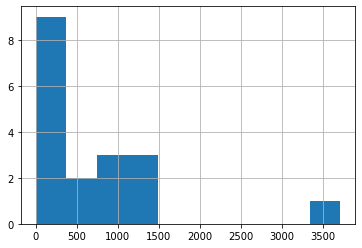

In [54]:
# whether we need to do td-idf
investor_style_sub[4].sum(axis=0).hist()

In [55]:
investor_style_sub[4].sum(axis=0).sort_values()

SpecDesc_
InvStyle_Technicals                  0.0
InvStyle_Quantitative               21.0
InvStyle_Private Equity             23.0
InvStyle_Growth                     29.0
InvStyle_Social Awareness           65.0
InvStyle_Sector Rotational          67.0
InvStyle_Venture Capital            89.0
InvStyle_Shareholder Activist      171.0
InvStyle_Special Situations        197.0
InvStyle_Index                     458.0
InvStyle_GARP                      726.0
InvStyle_Short Selling             958.0
InvStyle_Value                    1082.0
InvStyle_Income                   1107.0
InvStyle_Arbitrage                1230.0
InvStyle_Aggres. Gr.              1306.0
InvStyle_Convertible Arbitrage    1380.0
InvStyle_Emerging Markets         3711.0
dtype: float64

In [56]:
# compute weight, use idf
industry_weight = np.log(len(investor_style_sub) / (investor_style_sub[1].count(axis=0) + 1))
invStyle_weight = np.log(len(investor_style_sub) / (investor_style_sub[4].count(axis=0) + 1))

In [57]:
# normalize
def normalize(df):
  return df.div(df.sum(axis=1),axis=0).fillna(0)

industry_sub = normalize(investor_style_sub[1])
invStyle_sub = normalize(investor_style_sub[4])

In [58]:
industry_sub

SpecDesc_,Industry_Aerospace/Defense,Industry_Agricultural Products,Industry_Air Freight,Industry_Airlines,Industry_Aluminum,Industry_Auto Parts & Equipment,Industry_Automobiles,Industry_Autos/Auto Parts,Industry_Banks & Thrifts,Industry_Banks (Major Regional),Industry_Banks (Money Center),Industry_Banks (Regional),Industry_Beverages (Alcoholic),Industry_Beverages (Non-Alcoholic),Industry_Biofuels,Industry_Biotechnology,"Industry_Broadcasting (TV,Radio,Ca",Industry_Building Materials,Industry_Business Cyclicals,Industry_Business Staples,Industry_Cellular/Wireless Telecom,Industry_Chemicals,Industry_Clean technology,Industry_Communication Services,Industry_Communications Equipment,Industry_Computer Hardware,Industry_Computer Services,Industry_Computer Software,Industry_Computers (Networking),Industry_Computers (Peripherals),Industry_Consumer (Jewelry/Novelti,Industry_Consumer Cyclicals,Industry_Consumer Discretionary,Industry_Consumer Electronics,Industry_Consumer Finance,Industry_Consumer Staples,Industry_Containers-Metal & Glass,Industry_Containers/Packaging (Pap,Industry_Distributors (Durables),Industry_Distributors (Food & Heal,...,Industry_Renewable Energy,Industry_Restaurants,Industry_Retail,Industry_Retail (Building Supplies,Industry_Retail (Computers/Electro,Industry_Retail (Discounters/Offpr,Industry_Retail (Footwear),Industry_Retail (Home Items),Industry_Retail (Home Shopping/Cat,Industry_Retail Specialty-Apparel,Industry_Retail Stores-Dept Stores,Industry_Retail Stores-Drug Store,Industry_Retail Stores-Food Chains,Industry_Retail Stores-Gen Mer Cha,Industry_Retail-Specialty,Industry_Savings & Loan Companies,Industry_Semiconductors,Industry_Services (Advertising/Mkt,Industry_Services (Commercial Cons,Industry_Services (Employment),Industry_Services (Facils/Enviromn,Industry_Services (Payroll Process,Industry_Services (Rentals),Industry_Shipping,Industry_Specialty Communications,Industry_Steel,Industry_Technology,Industry_Telecommunication Service,Industry_Telephone (Local),Industry_Telephone-Local,Industry_Telephone-Long Distance,Industry_Textiles,Industry_Tobacco,Industry_Transportation,Industry_Truckers,Industry_Trucks & Parts,Industry_Utilities,Industry_Waste Management,Industry_Water Technology,Industry_Water Utilities
LgcyInvestorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000264,0.018692,0.037383,0.0,0.0,0.000000,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037383,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.037383,0.000000,0.000000,0.037383,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.028037,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.028037,0.0,0.037383,0.252336,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.018692,0.000000,0.000000,0.0,0.037383,0.000000,0.0,0.000000,0.000000
2001934,0.016563,0.016563,0.0,0.0,0.000000,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018634,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006211,0.004141,0.000000,0.00,0.000000,0.016563,0.000000,0.000000,0.018634,0.0,0.000000,0.004141,0.0,0.000000,0.000000,0.006211,0.006211,0.000000,0.000000,0.0,...,0.0,0.018634,0.000000,0.0,0.008282,0.000000,0.000000,0.002070,0.000000,0.008282,0.0,0.018634,0.320911,0.004141,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00207,0.000000,0.000000,0.000000,0.016563,0.000000,0.000000,0.0,0.018634,0.008282,0.0,0.002070,0.000000
2001935,0.009174,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.009174,0.000000,0.000000,0.0,...,0.0,0.0091

In [59]:
# compute distance 
invStyle_matrix = pd.DataFrame(euclidean_distances(industry_sub),index =industry_sub.index,columns=industry_sub.index)

In [ ]:
# invStyle_matrix.to_csv('invStyle_distance.csv')

## Feature: Number of instruments

In [60]:
n_instruments = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).agg({'INSTRID':'count'}).reset_index()
n_instruments_pivot = pd.pivot_table(n_instruments,index=['LGCYINVESTORID'],columns=['HOLDDATE'],values=['INSTRID']).fillna(0)

In [61]:
n_instruments_pivot.columns = n_instruments_pivot.columns.droplevel()

In [62]:
n_instruments_pivot_static = n_instruments.groupby('LGCYINVESTORID').agg({'INSTRID':'max'})

## Feature: Total Asset

In [63]:
total_asset = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).agg({'SHSHLDVAL_Sum_ByQuarter':'max'}).reset_index()
n_instruments_pivot = pd.pivot_table(df_sub,index=['LGCYINVESTORID'],columns=['SHSHLDVAL_Sum_ByQuarter'],values=['INSTRID']).fillna(0)

In [64]:
total_asset = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).agg({'SHSHLDVAL_Sum_ByQuarter':'max'}).reset_index()
total_asset_pivot = pd.pivot_table(total_asset,index=['LGCYINVESTORID'],columns=['HOLDDATE'],values=['SHSHLDVAL_Sum_ByQuarter']).fillna(0)

In [65]:
total_asset_pivot.columns = total_asset_pivot.columns.droplevel()

In [66]:
total_asset_pivot_static = total_asset.groupby('LGCYINVESTORID').agg({'SHSHLDVAL_Sum_ByQuarter':'max'})

## Feature: pctportofolio with aggregated **Industry**

In [67]:
df_industry_raw = pd.read_csv('/content/gdrive/My Drive/capstone/full database/portfolio_with_industry.csv')

In [176]:
# df_industry_raw.loc[((df_industry_raw['LGCYINVESTORID']==2578454) & (df_industry_raw['INSTRID']==8589934707)), :]

In [68]:
df_industry = df_industry_raw.copy()
df_industry = df_industry[['INSTRID', 'HOLDDATE', 'EndDate', 'HierarchicalId', 'Title']]
df_industry = df_industry.drop_duplicates()

In [75]:
df_industry['HOLDDATE'] = df_industry['HOLDDATE'].str.replace(r' 00:00:00', '')
df_industry['EndDate'] = df_industry['EndDate'].str.replace(r' 00:00:00.000', '')

# df_industry['HOLDDATE'] = pd.to_datetime(df_industry['HOLDDATE'], format='%Y-%m-%d')
# df_industry['EndDate'] = pd.to_datetime(df_industry['EndDate'], format='%Y-%m-%d')

In [76]:
df_industry['EndDate'].fillna('2020-11-11', inplace=True)

In [77]:
print(len(set(df_industry.loc[df_industry['EndDate'] == '2020-11-11',:].INSTRID)))
df_industry_latest = df_industry.loc[df_industry['EndDate'] == '2020-11-11',:].dropna()
len(set(df_industry_latest.INSTRID))

10018


8547

In [78]:
df_industry_latest['HierarchicalId'] = df_industry_latest['HierarchicalId'].astype(str).str[0:4]

In [79]:
len(set(df_industry_latest.HierarchicalId))

30

In [204]:
industry_merge = pd.merge(df_sub, df_industry_latest, how='inner', on=['INSTRID', 'HOLDDATE'])[['LGCYINVESTORID','HOLDDATE','PCTPORTFOLIO_13F','HierarchicalId']]

agg_industry_pivot = pd.pivot_table(industry_merge,index = ['LGCYINVESTORID', 'HOLDDATE'], columns = ['HierarchicalId'],values=['PCTPORTFOLIO_13F'],aggfunc=[np.sum],fill_value=0)

ind_investor_set = set(agg_industry_pivot.index.get_level_values('LGCYINVESTORID'))
ind_holddate_set = set(agg_industry_pivot.index.get_level_values('HOLDDATE'))

In [205]:
len(set(industry_merge['LGCYINVESTORID']))

199

In [206]:
# fill industry pct of any missing date with 0

industry_id_list = [HierarchicalId for (_,_,HierarchicalId) in list(agg_industry_pivot.columns)]

agg_industry_pivot.columns = industry_id_list
agg_industry_pivot = agg_industry_pivot.reset_index()
for inv in ind_investor_set:
  holddates = set(agg_industry_pivot[agg_industry_pivot['LGCYINVESTORID']==inv]['HOLDDATE'].to_list())
  if len(holddates) < len(ind_holddate_set):
    missing_dates = holddate_set - holddates
    for md in missing_dates:
      agg_industry_pivot = agg_industry_pivot.append([{'LGCYINVESTORID': inv, 'HOLDDATE':md}])

agg_industry_pivot = agg_industry_pivot.fillna(0)

In [207]:
agg_industry_pivot = agg_industry_pivot.set_index(['LGCYINVESTORID','HOLDDATE']).stack().reset_index()
agg_industry_pivot = agg_industry_pivot.rename(columns={agg_industry_pivot.columns[-2]:'Industry',agg_industry_pivot.columns[-1]:'PCTPORTFOLIO_13F'})

agg_industry_pivot = agg_industry_pivot.pivot_table(index=['LGCYINVESTORID'],columns=['HOLDDATE', 'Industry'],values=['PCTPORTFOLIO_13F'])
agg_industry_pivot.columns =  agg_industry_pivot.columns.droplevel()

In [208]:
agg_industry_pivot

HOLDDATE       2016-06-30                      ... 2020-06-30                    
Industry             5010      5020      5030  ...       5910      6010      6310
LGCYINVESTORID                                 ...                               
2000264          0.031676  0.000000  0.000000  ...   0.000000  0.000000  0.000000
2001934          0.054385  0.000149  0.000009  ...   0.021386  0.029338  0.000677
2001935          0.063725  0.000220  0.000040  ...   0.011725  0.015754  0.002517
2001989          0.042665  0.000000  0.000000  ...   0.000337  0.029318  0.013401
2001999          0.059102  0.000428  0.000002  ...   0.032040  0.052570  0.001675
...                   ...       ...       ...  ...        ...       ...       ...
6921752          0.000000  0.000000  0.000000  ...   0.011446  0.005289  0.007085
7185253          0.146024  0.000000  0.000000  ...   0.046666  0.016628  0.007076
9113038          0.000000  0.000000  0.000000  ...   0.031927  0.040263  0.001111
10075382         0.000000  0.000000  0.000000  ...   0.028453  0.025299  0.000000
10110259         0.000000  0.000000  0.000000  ...   0.106012  0.033001  0.001356

[199 rows x 510 columns]

## K_means

In [113]:
agg_mktcap_pivot.head(1)

HOLDDATE       2016-06-30                     ... 2020-06-30                     
MktCap            MegaCap MicroCap    MidCap  ...    NanoCap PctLargeCap SmallCap
LGCYINVESTORID                                ...                                
2000264          0.212474      0.0  0.058278  ...        0.0    0.503845      0.0

[1 rows x 102 columns]

In [114]:
# one company no turnover
turnover_pivot.head(1)

EffectToDate,2016-09-30 00:00:00,2016-12-31 00:00:00,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00
LgcyInvestorId,,,,,,,,,,,,,,,,
2000264,86.452,85.8361,100.8113,115.1844,112.7026,118.2662,105.4643,88.2367,78.9487,76.0084,75.2375,87.28,87.7139,85.7696,92.4672,109.2843


In [115]:
concentration_pivot.head(1)

HOLDDATE,2016-06-30,2016-09-30,2016-12-31,2017-03-31,2017-06-30,2017-09-30,2017-12-31,2018-03-31,2018-06-30,2018-09-30,2018-12-31,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30
LGCYINVESTORID,,,,,,,,,,,,,,,,,
2000264,0.383612,0.335504,0.338615,0.398285,0.397128,0.337557,0.325483,0.34506,0.299875,0.363706,0.344221,0.325613,0.365666,0.384265,0.403435,0.423236,0.339052


In [116]:
industry_sub.head(1)

SpecDesc_,Industry_Aerospace/Defense,Industry_Agricultural Products,Industry_Air Freight,Industry_Airlines,Industry_Aluminum,Industry_Auto Parts & Equipment,Industry_Automobiles,Industry_Autos/Auto Parts,Industry_Banks & Thrifts,Industry_Banks (Major Regional),Industry_Banks (Money Center),Industry_Banks (Regional),Industry_Beverages (Alcoholic),Industry_Beverages (Non-Alcoholic),Industry_Biofuels,Industry_Biotechnology,"Industry_Broadcasting (TV,Radio,Ca",Industry_Building Materials,Industry_Business Cyclicals,Industry_Business Staples,Industry_Cellular/Wireless Telecom,Industry_Chemicals,Industry_Clean technology,Industry_Communication Services,Industry_Communications Equipment,Industry_Computer Hardware,Industry_Computer Services,Industry_Computer Software,Industry_Computers (Networking),Industry_Computers (Peripherals),Industry_Consumer (Jewelry/Novelti,Industry_Consumer Cyclicals,Industry_Consumer Discretionary,Industry_Consumer Electronics,Industry_Consumer Finance,Industry_Consumer Staples,Industry_Containers-Metal & Glass,Industry_Containers/Packaging (Pap,Industry_Distributors (Durables),Industry_Distributors (Food & Heal,...,Industry_Renewable Energy,Industry_Restaurants,Industry_Retail,Industry_Retail (Building Supplies,Industry_Retail (Computers/Electro,Industry_Retail (Discounters/Offpr,Industry_Retail (Footwear),Industry_Retail (Home Items),Industry_Retail (Home Shopping/Cat,Industry_Retail Specialty-Apparel,Industry_Retail Stores-Dept Stores,Industry_Retail Stores-Drug Store,Industry_Retail Stores-Food Chains,Industry_Retail Stores-Gen Mer Cha,Industry_Retail-Specialty,Industry_Savings & Loan Companies,Industry_Semiconductors,Industry_Services (Advertising/Mkt,Industry_Services (Commercial Cons,Industry_Services (Employment),Industry_Services (Facils/Enviromn,Industry_Services (Payroll Process,Industry_Services (Rentals),Industry_Shipping,Industry_Specialty Communications,Industry_Steel,Industry_Technology,Industry_Telecommunication Service,Industry_Telephone (Local),Industry_Telephone-Local,Industry_Telephone-Long Distance,Industry_Textiles,Industry_Tobacco,Industry_Transportation,Industry_Truckers,Industry_Trucks & Parts,Industry_Utilities,Industry_Waste Management,Industry_Water Technology,Industry_Water Utilities
LgcyInvestorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000264,0.018692,0.037383,0.0,0.0,0.0,0.009346,0.0,0.0,0.0,0.0,0.0,0.0,0.037383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037383,0.0,0.0,0.037383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028037,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028037,0.0,0.037383,0.252336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018692,0.0,0.0,0.0,0.037383,0.0,0.0,0.0,0.0


In [117]:
# normalize turnover_pivot
max_turnover = turnover_pivot.max().max()
turnover_pivot_standard = turnover_pivot/max_turnover

In [118]:
# normalize number of instruments
max_n_instruments = n_instruments_pivot.max().max()
n_instruments_pivot_standard = n_instruments_pivot/max_n_instruments
n_instruments_pivot_static_standard = n_instruments_pivot_static/max_n_instruments

In [119]:
# normalize total asset
max_total_asset = total_asset_pivot.max().max()
total_asset_pivot_standard = total_asset_pivot/max_total_asset
total_asset_pivot_static_standard = total_asset_pivot_static/max_total_asset

In [221]:
X = pd.concat([agg_mktcap_pivot,
               agg_industry_pivot,
               turnover_pivot_standard, 
               n_instruments_pivot_static_standard,
               total_asset_pivot_static_standard,
               concentration_pivot,
               invStyle_sub], axis=1).fillna(0)


X = agg_mktcap_pivot
X_sub = X[X.index.isin(active_ls_investors.LgcyInvestorId)]

In [142]:
# for col in X.columns:
#   print(col)

In [144]:
from sklearn.cluster import KMeans

def fit_kmeans(n_components,X):
    km = KMeans(n_components)
    km.fit(X)
    predictions = km.predict(X)
    return predictions

In [145]:
from sklearn.manifold import TSNE

def draw_tsne(X, predictions=None):
    tsne = TSNE(n_components=2)
    x = tsne.fit_transform(X)
    if predictions is None:
      plt.scatter(x[:,0],x[:,1])
      plt.title('pctportfolio clustering')
    else:
      plt.scatter(x[:,0],x[:,1],c=predictions)
      plt.title('pctportfolio clustering')      

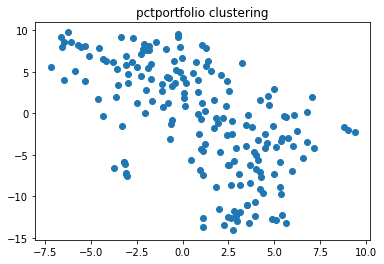

In [222]:
draw_tsne(X_sub)

In [147]:
from sklearn import metrics
from sklearn.cluster import SpectralClustering

def InternalEvaluation(data, clusters):
    scores = {}
    """
    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. 
    Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    """
    scores['_silhouette_score'] =metrics.silhouette_score(data,clusters ,metric='euclidean')
    """
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    The score is fast to compute
    """
    scores['_calinski_harabaz_score'] = metrics.calinski_harabasz_score(data,clusters)
    """
    Zero is the lowest possible score. Values closer to zero indicate a better partition.
    The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, 
    such as density based clusters like those obtained from DBSCAN.
    """
    scores['_davies_bouldin_score'] = metrics.davies_bouldin_score(data,clusters)
    return scores

def draw_scores(scores, start_k=2):
  score_type = list(scores[0].keys())
  n_type = len(score_type)
  plt.figure(figsize=(8,4))
  for i in range(n_type):
    sc_type = score_type[i]
    score = [sc[sc_type] for sc in scores]
    plt.subplot(1, n_type, i+1)
    plt.plot(range(start_k,len(score) + start_k ), score)
    plt.title(' '.join(sc_type.split('_')).title())
    plt.xlabel('k')
  plt.suptitle('Metrics for Clustering')

In [223]:
def modeling(X):
  scores = []
  for k in range(2, 10):
    predictions = fit_kmeans(k,X)
    score = InternalEvaluation(X, predictions)
    scores.append(score)
  plt.figure(1)
  draw_scores(scores)
  plt.figure(2)
  # draw_tsne(X)

In [136]:
# agg_mktcap_pivot,
#               #  turnover_pivot, 
#                concentration_pivot,invStyle_sub

<Figure size 432x288 with 0 Axes>

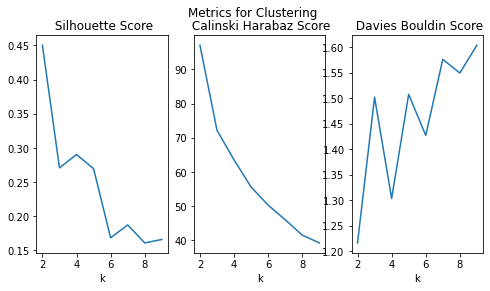

In [224]:
modeling(X_sub)


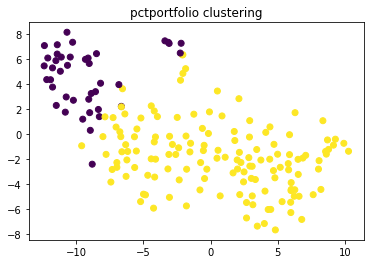

In [225]:
predictions = fit_kmeans(2,X_sub)
draw_tsne(X_sub,predictions)

<Figure size 432x288 with 0 Axes>

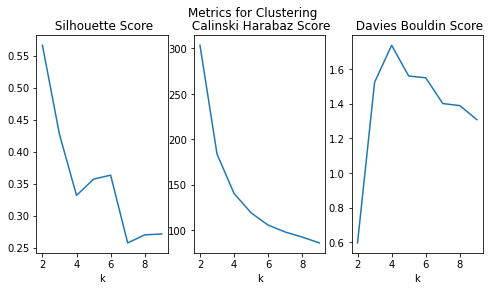

In [219]:
# [agg_mktcap_pivot,
#                agg_industry_pivot,
#                turnover_pivot_standard, 
#                n_instruments_pivot_static_standard,
#                total_asset_pivot_static_standard,
#                concentration_pivot,
#                invStyle_sub]

X = invStyle_sub
X_sub = X[X.index.isin(active_ls_investors.LgcyInvestorId)]

modeling(X_sub)

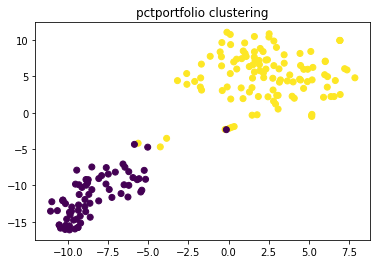

In [220]:
predictions = fit_kmeans(2,X_sub)
draw_tsne(X_sub,predictions)

In [229]:

result = pd.DataFrame({
    'investor': X_sub.index,
    'cluster': predictions
})

In [234]:
# output the clustering result and merge with investor names and save to drive
result_merge = pd.merge(df_sub, result, how='right', left_on=['LGCYINVESTORID'], right_on=['investor'])[['FULLNAME','LGCYINVESTORID','cluster']].drop_duplicates()
result_merge.to_csv('/content/gdrive/My Drive/capstone/distance matrix/all_cluster_result.csv')